## Neighbourhood clustering (categorical labels)

Neighbourhood clustering is a common method for identifying common collections of highly localised cells and it is typically used when studying local interactions of cells. Neighbourhood clustering can be seen as generating a local-spatially resolved cell annotation from existing annotations. This process is conducted in three steps:

1. Gather local information (cell counts, mean intensity, transcript counts, etc) about points of interest using some network representing spatial relations.

2. Store local information for all points in a global matrix.

3. Cluster observations.

In MuSpAn, we leverage the flexibility of our `muspan.networks` submodule and the sklearn clustering packages (via `muspan.helpers.cluster_data`) to allow a combination of spatial relation of points and how they are clustered. In this tutorial, we will explore how we might use our `cluster_neighbourhoods` functionality ranging from commonly used methods in literature to our recommendations. Critically, this tutorial should also serve as a demonstration of the sensitivity of resultant neighbourhoods to both the spatial networks and clustering method used. Before using this function, we also recommend seeing our documentation on `cluster_neighbourhoods` to get and understanding of the parameters associated.

We'll start with the most basic case of finding neighbourhood clusters in a single domain.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

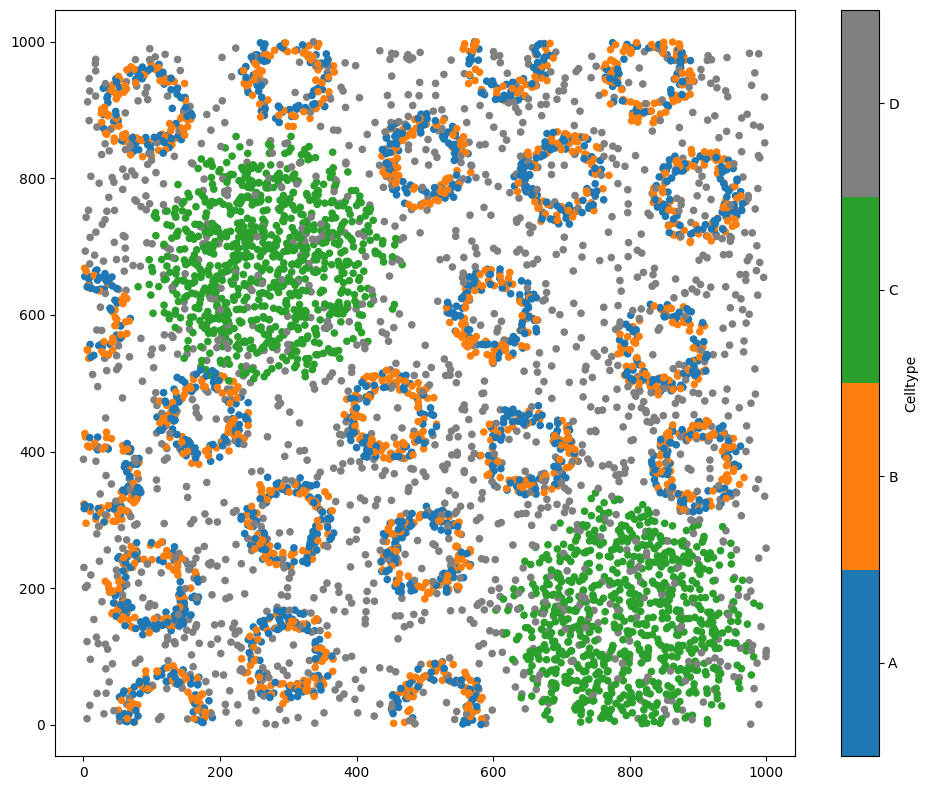

In [1]:
# Import necessary libraries
import muspan as ms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load an example domain dataset
pc = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Visualize the dataset, coloring by 'Celltype'
ms.visualise.visualise(pc, color_by='Celltype')

A common implementation of neighbourhood clustering in cancer biology is to simply get the k-closest (k=10) points about all points in a region and use kmeans clustering (note a different k). For example, Sch&uuml;rch et al. used this approach in understanding immune spatial organisation in CRC (https://doi.org/10.1016/j.cell.2020.07.005).

We can reproduce their implementation by using our `KNN` spatial network generation, with 10 neighbours and selecting the `minibatchkmeans` clustering methods with 4 clusters as shown below where we apply this clustering procedure to our synthetic data using the 'Celltype' label.

In [2]:
# Perform neighbourhood clustering on the dataset using KNN and minibatchkmeans
neighbourhood_enrichment_matrix, consistent_global_labels, unique_cluster_labels = ms.networks.cluster_neighbourhoods(
    pc,  # The domain dataset
    label_name='Celltype',  # The label to use for clustering
    network_kwargs=dict(network_type='KNN', max_edge_distance=np.inf, min_edge_distance=0, number_of_nearest_neighbours=10),  # The network parameters
    k_hops=1,  # The number of hops to consider for the neighbourhood
    neighbourhood_label_name='Neighbourhood ID',  # Name for the neighbourhood label
    cluster_method='minibatchkmeans',  # Clustering method
    cluster_parameters={'n_clusters': 4},  # Parameters for the clustering method
    neighbourhood_enrichment_as='log-fold' # Neighbourhood enrichment as log-fold 
)


The function has three outputs:
1. A differential expression matrix where rows represent cluster IDs and rows are labels used in to cluster. Here this is presented as log-fold change to match the Sch&uuml;rch et al. pipeline but our default is a zscore.

2. The labels used to cluster the neighbourhoods

3. A list of the resultant cluster labels

4. (Optional) The observation matrix of neighbourhood compositions used to cluster. This is not output here but can be, see our documentation on `cluster_neighbourhoods`.

We can visualise the differential expression matrix using `ms.visualise.heatmap` or if we want to show similarities of clusters, we can use the sns.heatmap function as shown below.

In [3]:
neighbourhood_enrichment_matrix

array([[ 8.21179029e-001, -1.79769313e+308,  7.95087029e-001,
        -5.94413265e+000],
       [-7.26832663e+000, -7.78131358e-002, -7.06418844e+000,
         1.61811039e+000],
       [ 6.51506221e-001,  9.42742864e-002,  6.58169524e-001,
        -6.71515608e+000],
       [-1.01149273e+000,  1.21052595e+000, -9.92964275e-001,
        -2.77009642e+000]])

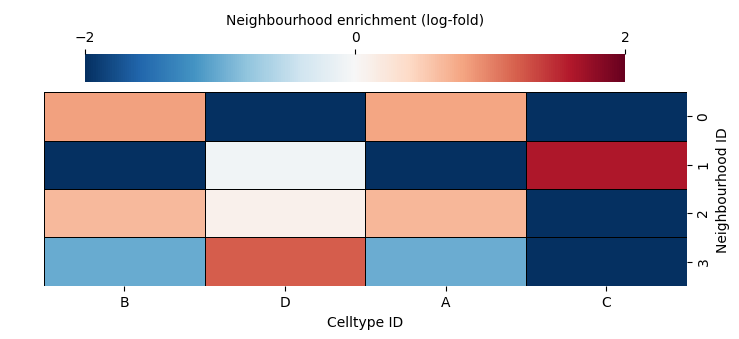

In [4]:
# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=unique_cluster_labels, columns=consistent_global_labels)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Celltype ID'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=consistent_global_labels,
    yticklabels=unique_cluster_labels,
    figsize=(7.5, 3.5),
    cmap='RdBu_r',
    dendrogram_ratio=(.05, .3),
    col_cluster=False,
    row_cluster=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (log-fold)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)

We can see this neigbourhood clustering method has found two very similar clusters (4 and 0) and the rest picking a dominant celltype. This makes sense as there are only 4 celltypes in our dataset. The `cluster_neighbourhoods` function automatically adds these cluster labels to the objects that were used in the computation using the and is identified by the `neighbourhood_label_name` parameter.

Using this label, let's see the result of the clustering spatially-resolved on our dataset.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

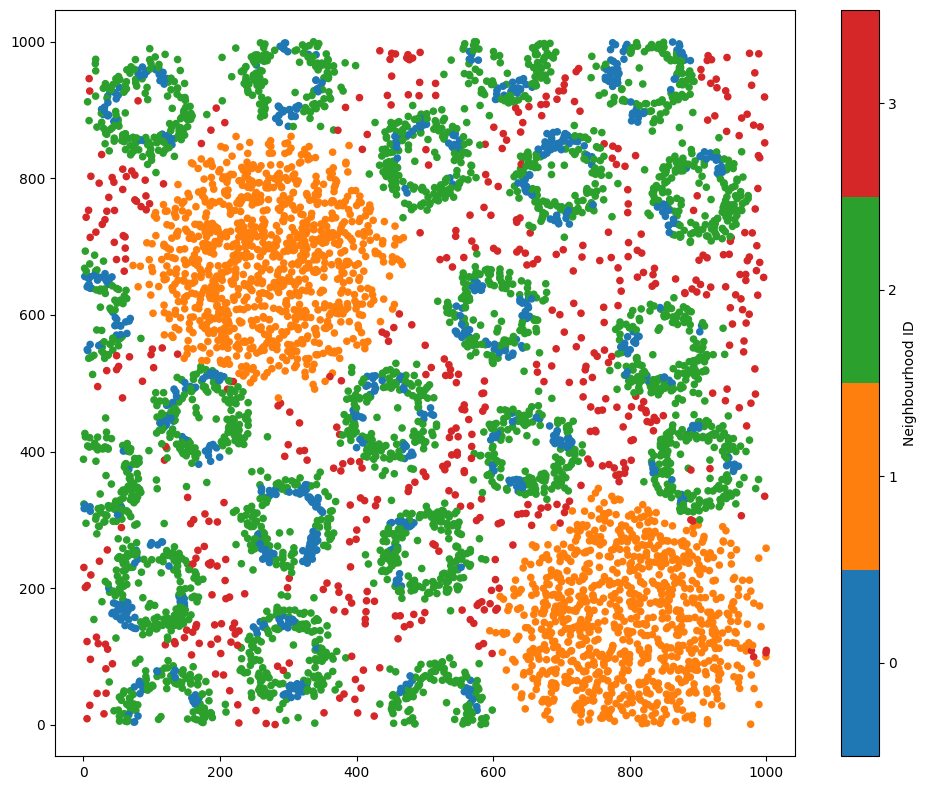

In [5]:
# Visualize the dataset with the neighbourhood clustering results
ms.visualise.visualise(pc, color_by='Neighbourhood ID')

Great, we can now see that Neighbourhoods 0 and 2 are identifying similar compositions of the crypt-like structures, Neighbourhood 3 is picking up the background noise celltype, and 1 and 3 are the aggregated masses of celltype C.

**Note:** It's always recommended to visualise these neighbourhood clusters on the data as a method of quality control. MuSpAn make this easy by automatically aligning neighbourhood labels with spatial data. In addition, assigning labels also allows for querying based on neighbourhood cluster for downstream spatial analysis.

Though we have clustered the localised counts of our celltypes, this is just one method of a vast range of possibilities facilitated by MuSpAn. Critically, this implementation ignores the spatial structure of the spatial domain and prescribes a number of resultant clusters. Later in this tutorial, we'll show alternative implementations that address these limitations.

### Neighbourhood clustering on specific objects 

In our above analysis, used all data in our domain to cluster neighbourhoods. It might be the case we'd like to only use subset of our data to compute neighbourhoods about. For this, we case use the `populations_to_analyse` parameter. We can pass any MuSpAn query-like object to filter our analysis objects. 

We'll demonstrate this by exluding points with label 'D' from the clustering.

In [6]:
# Query the dataset to exclude cells labeled 'D'
not_d_query = ms.query.query(pc, ('label', 'Celltype'), 'not in', ['D'])

In [7]:
# Perform neighbourhood clustering on the dataset excluding cells labeled 'D'
neighbourhood_enrichment_matrix, consistent_global_labels, unique_cluster_labels = ms.networks.cluster_neighbourhoods(
    pc,  # The domain dataset
    label_name='Celltype',  # The label to use for clustering
    populations_to_analyse=not_d_query,  # Exclude cells labeled 'D'
    network_kwargs=dict(network_type='KNN', max_edge_distance=np.inf, min_edge_distance=0, number_of_nearest_neighbours=10),  # The network parameters
    k_hops=1,  # Number of hops for KNN
    neighbourhood_label_name='Neighbourhood ID (not D)',  # Name for the neighbourhood label
    cluster_method='minibatchkmeans',  # Clustering method
    cluster_parameters={'n_clusters': 5},  # Parameters for the clustering method
    neighbourhood_enrichment_as='log-fold' # Neighbourhood enrichment as log-fold
)

Let's visualise the output of this clustering using our new label 'Neighbourhood ID (not D)'.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

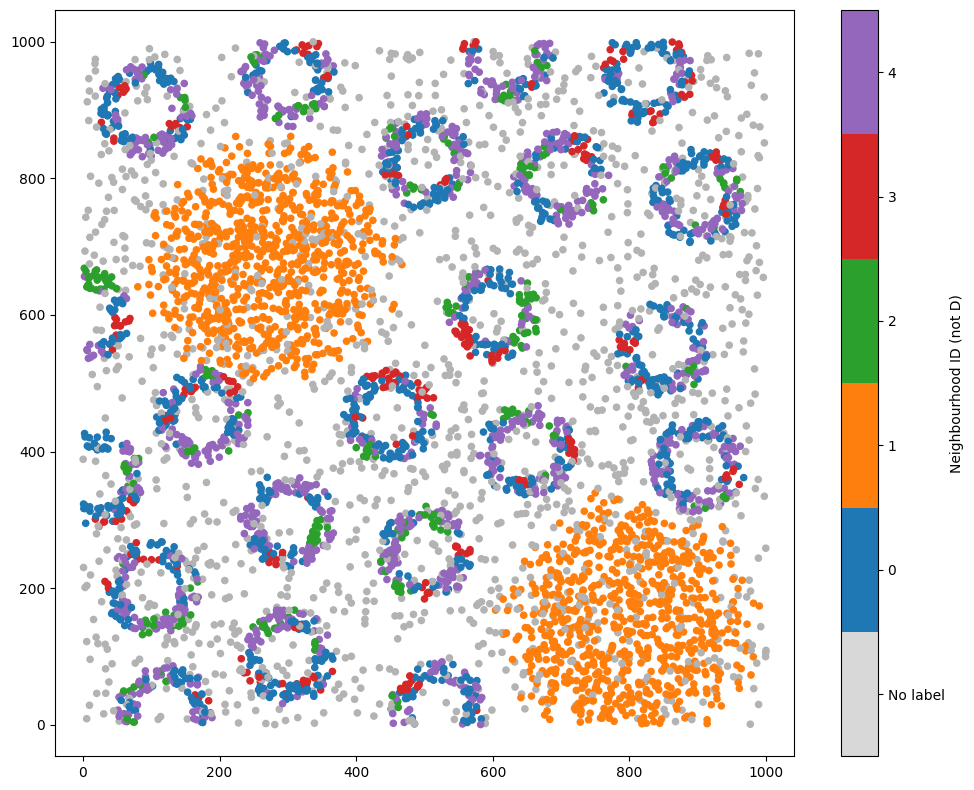

In [8]:
# Visualize the dataset with the neighbourhood clustering results excluding cells labeled 'D'
ms.visualise.visualise(pc, color_by='Neighbourhood ID (not D)')

Great, we can see points with label 'D' have been ignored from the neighbourhood clustering.

### Neighbourhood clustering over multiple domains

Another use case is the batch analysis approach where we might want to understand and group local compositions of functions across multiple domains. This is possible in MuSpAn by simply passing a list of domains to analyse. The querying functionality follows similarly by providing a list of queries to the function, if a query is required.

This approach gives a standarised neighbourhood ID respresentation across all domains which is useful when consider cross-cohort studies.

We'll demonstrate this batch approach on four of our synthetic datasets.

In [9]:
# Load example domains
pc1 = ms.datasets.load_example_domain('Synthetic-Points-Random')
pc2 = ms.datasets.load_example_domain('Synthetic-Points-Aggregation')
pc3 = ms.datasets.load_example_domain('Synthetic-Points-Exclusion')
pc4 = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Create a list of domains
list_of_domains = [pc1, pc2, pc3, pc4]

# Query cells to exclude those labeled 'D'
query_cells_list = []
for pc in list_of_domains:
    query_cells_list.append(ms.query.query(pc, ('label', 'Celltype'), 'not in', ['D']))

# Perform neighbourhood clustering on the list of domains
neighbourhood_enrichment_matrix, consistent_global_labels, unique_cluster_labels = ms.networks.cluster_neighbourhoods(
    list_of_domains,  # List of domain datasets
    label_name='Celltype',  # The label to use for clustering
    populations_to_analyse=query_cells_list,  # Exclude cells labeled 'D'
    network_kwargs=dict(network_type='KNN', max_edge_distance=np.inf, min_edge_distance=0, number_of_nearest_neighbours=10),  # The network parameters
    labels_to_ignore=['D'],  # Labels to ignore
    k_hops=1,  # Number of hops for KNN
    neighbourhood_label_name='Neighbourhood ID (KNN)',  # Name for the neighbourhood label
    cluster_method='minibatchkmeans',  # Clustering method
    cluster_parameters={'n_clusters': 4},  # Parameters for the clustering method
    neighbourhood_enrichment_as='log-fold' # Neighbourhood enrichment as log-fold
)


MuSpAn domain loaded successfully. Domain summary:
Domain name: Density
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


MuSpAn domain loaded successfully. Domain summary:
Domain name: Aggregation
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Exclusion
Number of objects: 2166
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


Again, labels are automatically assigned to all domains and therefore we can visualise the outputs.

(<Figure size 2000x1500 with 8 Axes>, <Axes: >)

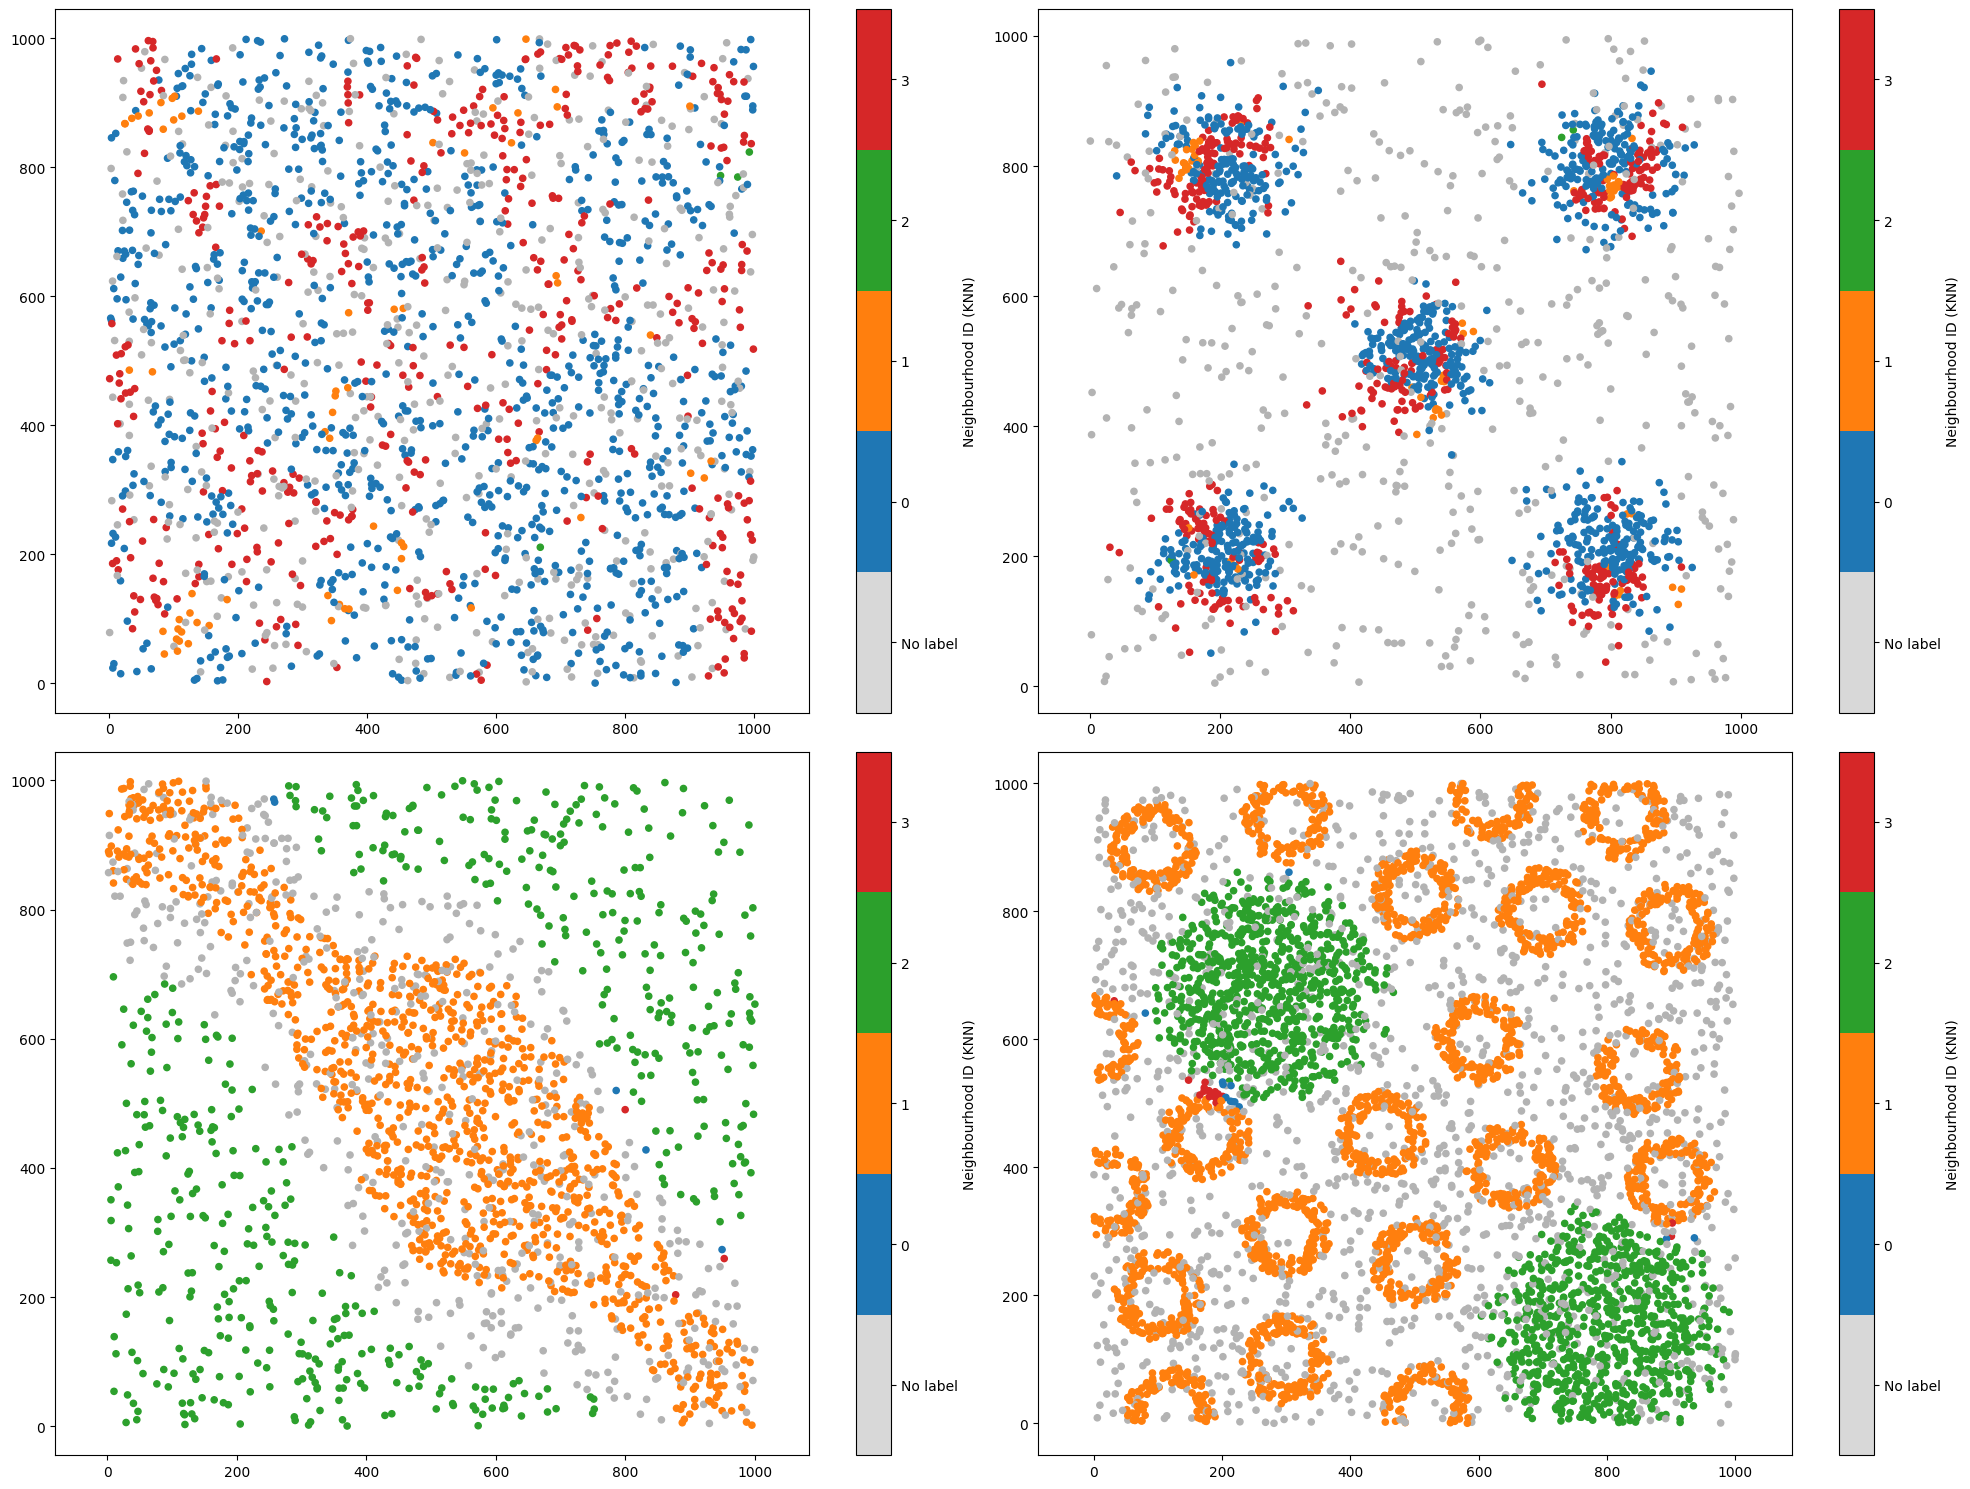

In [10]:
# Create a figure with 2x2 subplots
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, ncols=2)

# Visualize the neighbourhood clustering results for each domain
ms.visualise.visualise(pc1, color_by='Neighbourhood ID (KNN)', ax=ax[0, 0])
ms.visualise.visualise(pc2, color_by='Neighbourhood ID (KNN)', ax=ax[0, 1])
ms.visualise.visualise(pc3, color_by='Neighbourhood ID (KNN)', ax=ax[1, 0])
ms.visualise.visualise(pc4, color_by='Neighbourhood ID (KNN)', ax=ax[1, 1])

As before, we can also check out the differential expression matrix to inform the discrimminative types of each neighbourhood cluster.

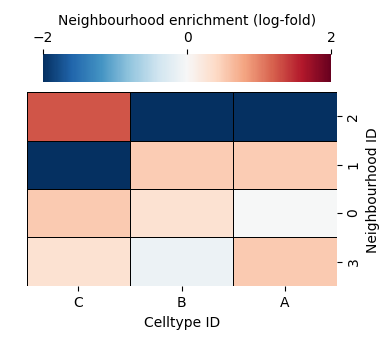

In [11]:
# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=unique_cluster_labels, columns=consistent_global_labels)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Celltype ID'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=consistent_global_labels,
    yticklabels=unique_cluster_labels,
    figsize=(4, 3.5),
    cmap='RdBu_r',
    dendrogram_ratio=(.05, .3),
    col_cluster=True,
    row_cluster=True,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (log-fold)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)

### Changing the network type

As hinted to earlier in this tutorial, we can use any spatial network representing cell-cell interaction to define local neighbourhoods about cells. KNN is one of these (used above) where the closest 10 objects will be used in clustering. However, if spatial structure is important in the your dataset, other network constructions such as Delaunay or proximity networks may be more appropriate. 

In this case, we can take advantage of our k-hop methods to define local objects. A k-hop neighbourhood about an object in a network is all other objects that can be reached by travelling down k or less edges. For an example of this, see our MuSpAn: Figure 5. example notebook.

Using our k-hop with a Delaunay network, we are using the instrinc spatial structure of our data by only considerng spatially locallised objects. Let's see this in action on our four synthetic datasets above, here only changing our underlying network.

In [12]:
# Perform neighbourhood clustering on the list of domains using Delaunay network and minibatchkmeans clustering
neighbourhood_enrichment_matrix, consistent_global_labels, unique_cluster_labels = ms.networks.cluster_neighbourhoods(
    list_of_domains,  # List of domain datasets
    label_name='Celltype',  # The label to use for clustering
    populations_to_analyse=query_cells_list,  # Exclude cells labeled 'D'
    network_kwargs=dict(network_type='Delaunay', max_edge_distance=50, min_edge_distance=0),  # The network parameters
    labels_to_ignore=['D'],  # Labels to ignore
    k_hops=3,  # Number of hops for Delaunay
    neighbourhood_label_name='Neighbourhood ID (Delaunay)',  # Name for the neighbourhood label
    cluster_method='minibatchkmeans',  # Clustering method
    cluster_parameters={'n_clusters': 4}  # Parameters for the clustering method
)


(<Figure size 2000x1500 with 8 Axes>, <Axes: >)

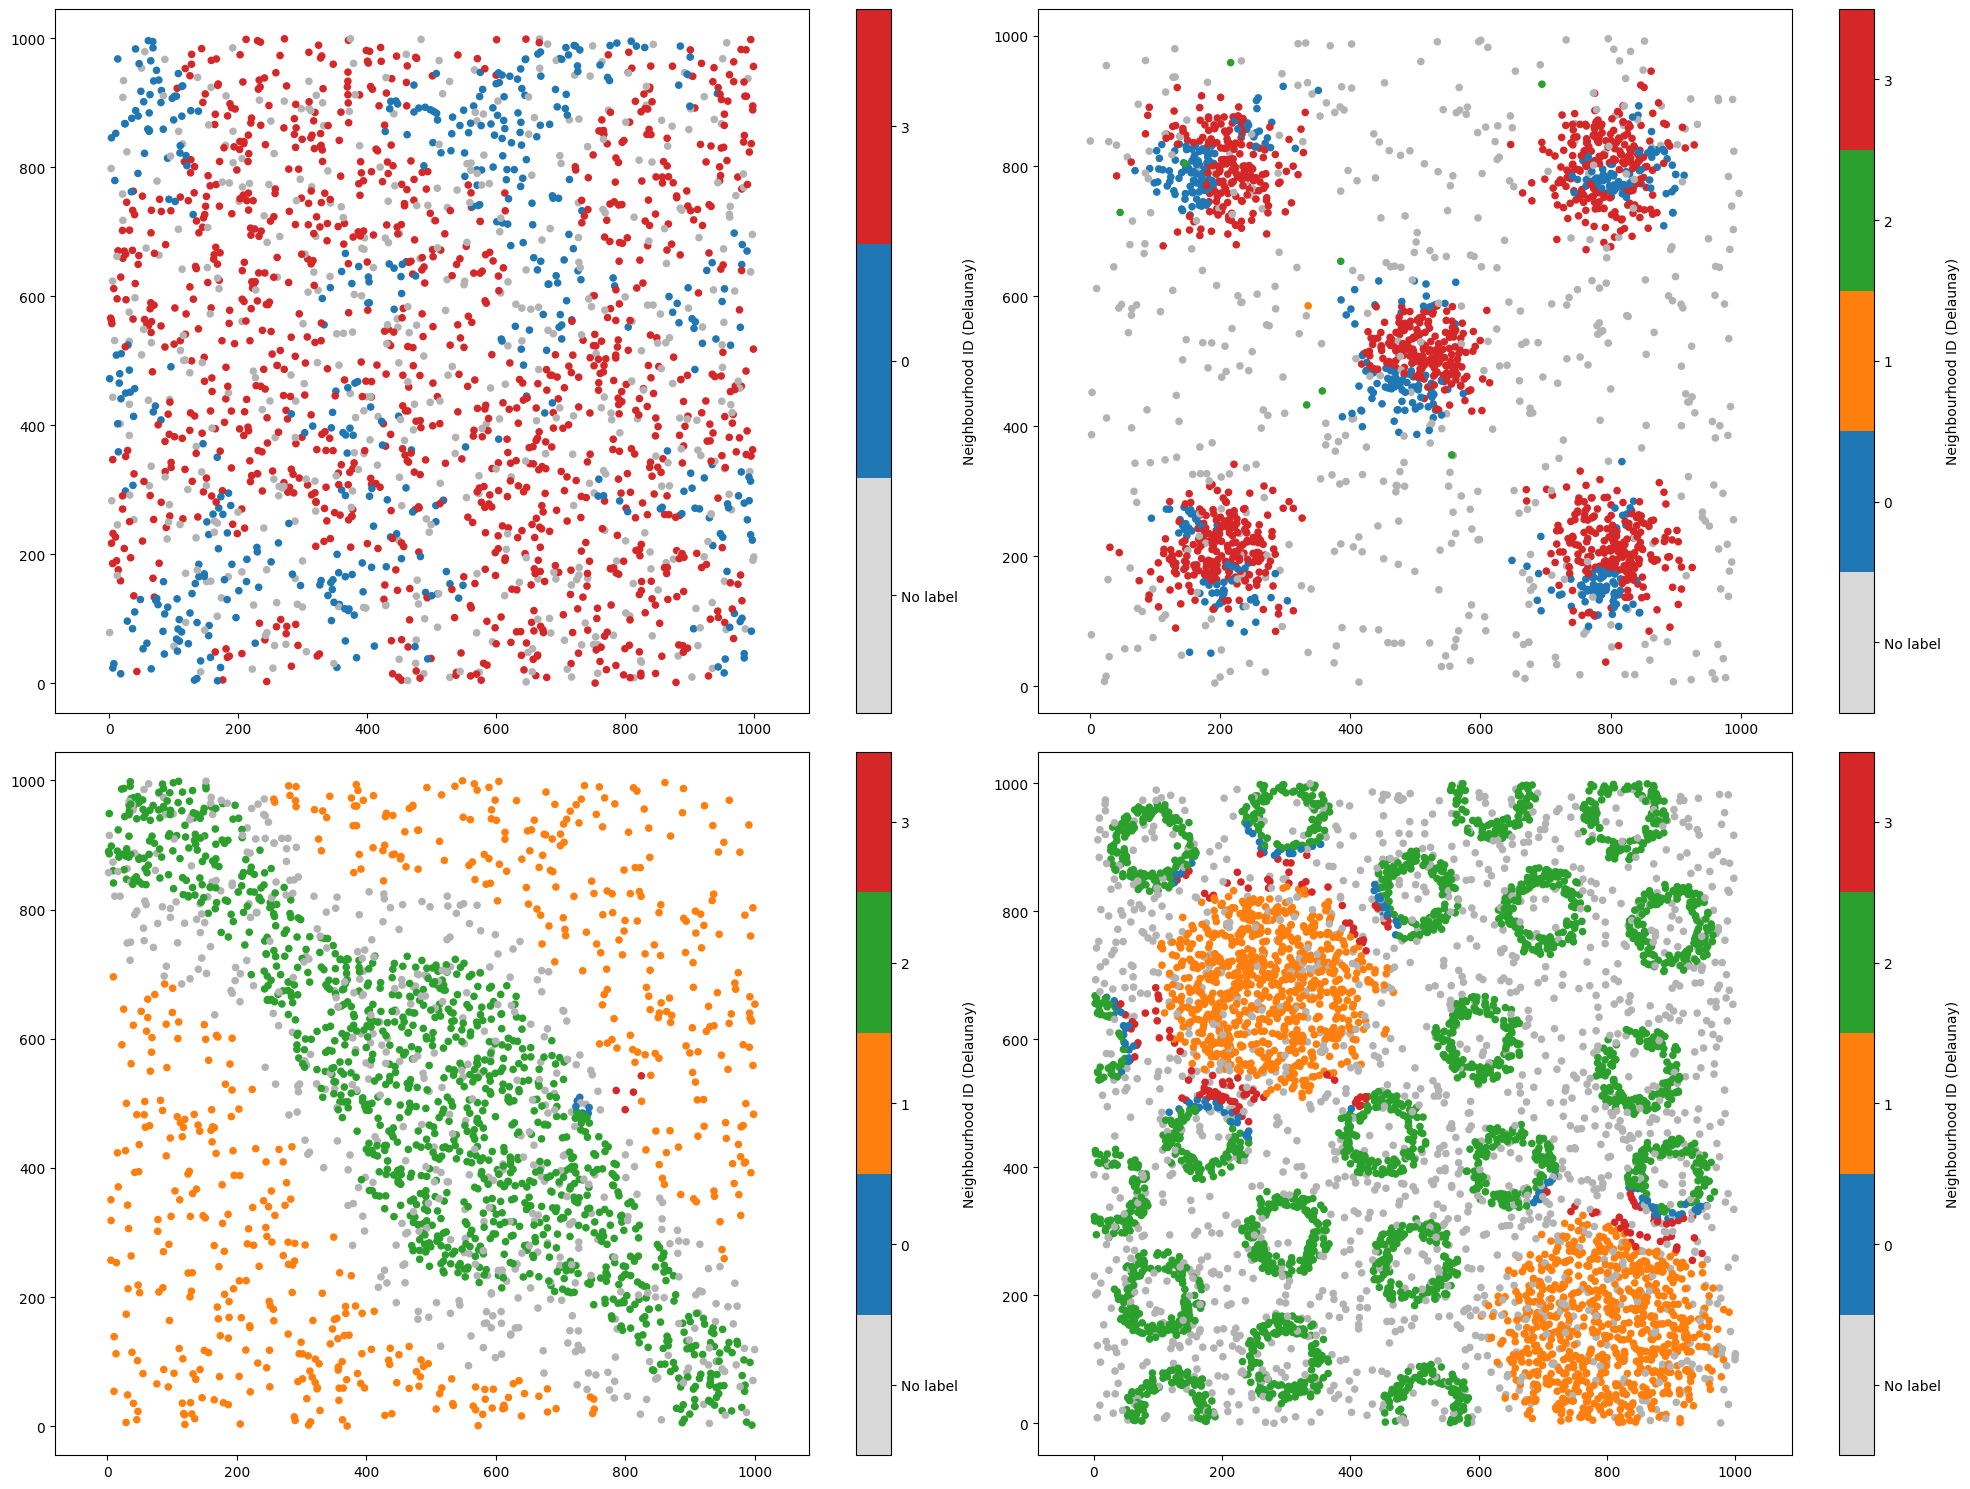

In [13]:
# Create a figure with 2x2 subplots
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, ncols=2)

# Visualize the neighbourhood clustering results for each domain using Delaunay network
ms.visualise.visualise(pc1, color_by='Neighbourhood ID (Delaunay)', ax=ax[0, 0])
ms.visualise.visualise(pc2, color_by='Neighbourhood ID (Delaunay)', ax=ax[0, 1])
ms.visualise.visualise(pc3, color_by='Neighbourhood ID (Delaunay)', ax=ax[1, 0])
ms.visualise.visualise(pc4, color_by='Neighbourhood ID (Delaunay)', ax=ax[1, 1])

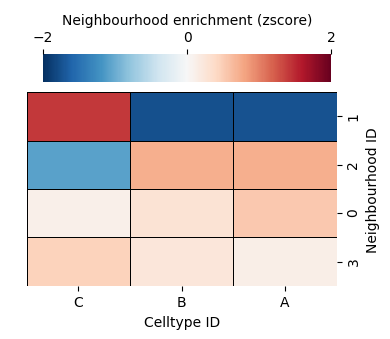

In [14]:
# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=unique_cluster_labels, columns=consistent_global_labels)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Celltype ID'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=consistent_global_labels,
    yticklabels=unique_cluster_labels,
    figsize=(4, 3.5),
    cmap='RdBu_r',
    dendrogram_ratio=(.05, .3),
    col_cluster=True,
    row_cluster=True,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (zscore)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)

Though our differential expression matrix is very similar to using the KNN network, our spatial locations of these labels can very different which is emphasised in our aggregated dataset (top right).

### Changing the clustering method

We can also change our clustering method to any provided in the sklearn package (https://scikit-learn.org/1.5/modules/clustering.html). Each clustering method comes equipped assumptions and is designed to detect specific features in the data. We recommend checking out the sklearn site before using clustering. 

In this example, we'll change our clustering method to a unsupervised-type (does not require prescibed number of groups). Namely, we'll use HDBSCAN which is a heiracharical distance-based clustering algorthim (https://scikit-learn.org/1.5/modules/clustering.html#hdbscan). This is process can produce unassigned data (those without clusters) which are labelled with a -1. 

In [15]:
# Perform neighbourhood clustering on the list of domains using Delaunay network and HDBSCAN clustering
neighbourhood_enrichment_matrix, consistent_global_labels, unique_cluster_labels = ms.networks.cluster_neighbourhoods(
    list_of_domains,  # List of domain datasets
    label_name='Celltype',  # The label to use for clustering
    populations_to_analyse=query_cells_list,  # Exclude cells labeled 'D'
    network_kwargs=dict(network_type='Delaunay', max_edge_distance=np.inf, min_edge_distance=0),  # The network parameters
    labels_to_ignore=['D'],  # Labels to ignore
    k_hops=3,  # Number of hops for Delaunay
    neighbourhood_label_name='Neighbourhood ID (Delaunay + HDBSCAN)',  # Name for the neighbourhood label
    cluster_method='HDBSCAN',  # Clustering method
    cluster_parameters={'min_cluster_size': 150}  # Parameters for the clustering method
)

(<Figure size 2000x1500 with 8 Axes>, <Axes: >)

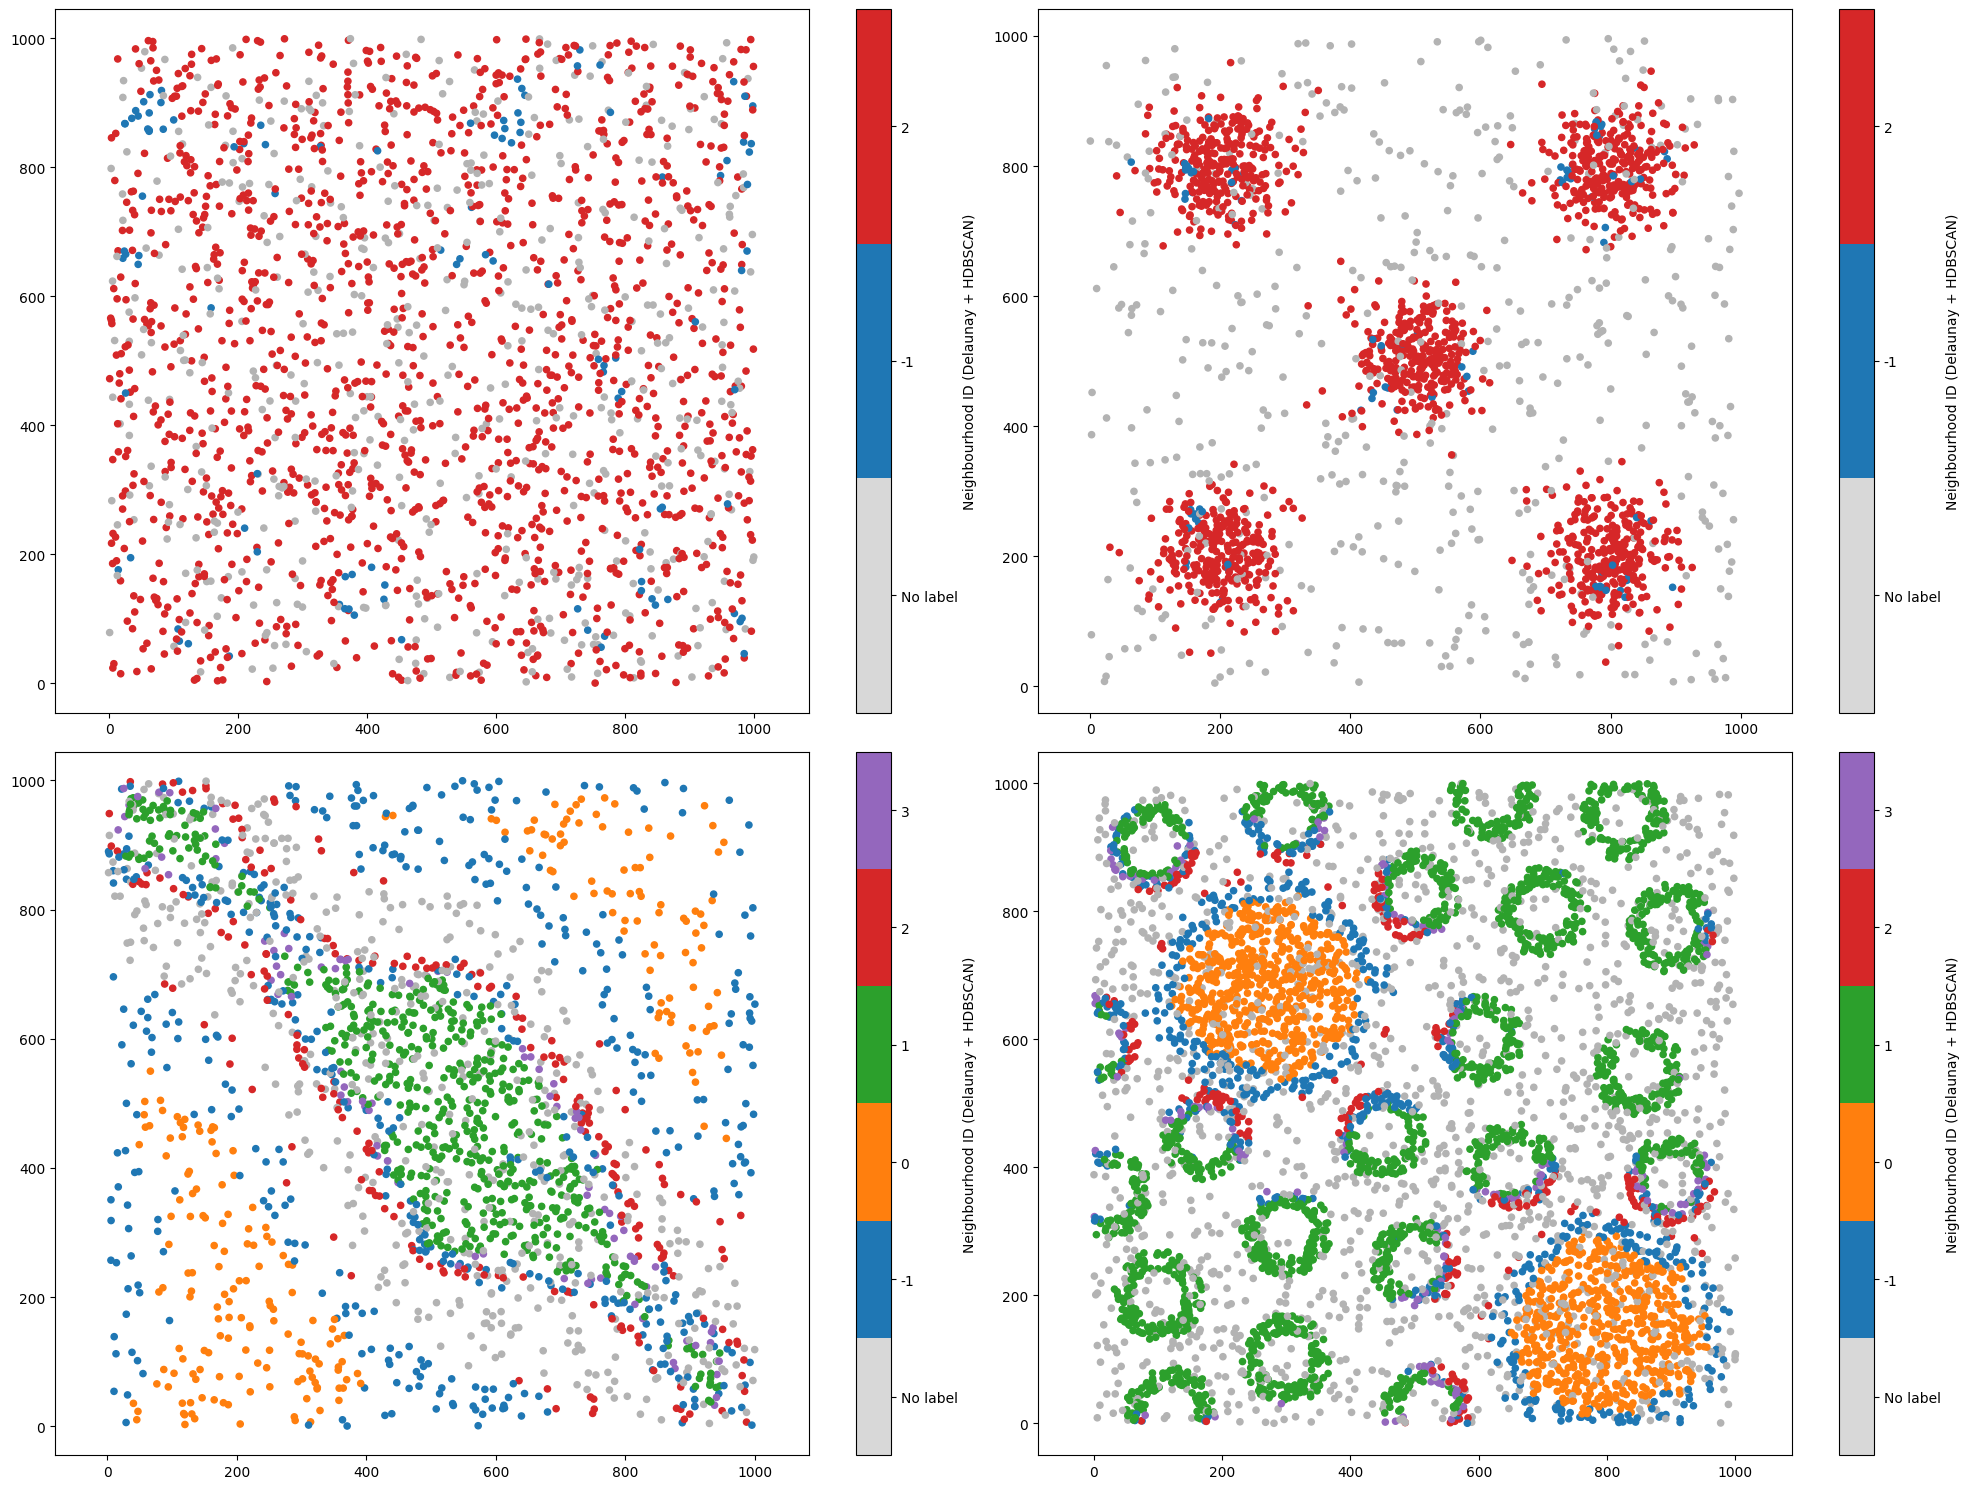

In [16]:
# Create a figure with 2x2 subplots for visualizing the neighbourhood clustering results
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, ncols=2)

# Visualize the neighbourhood clustering results for each domain using Delaunay network and HDBSCAN clustering
ms.visualise.visualise(pc1, color_by='Neighbourhood ID (Delaunay + HDBSCAN)', ax=ax[0, 0])
ms.visualise.visualise(pc2, color_by='Neighbourhood ID (Delaunay + HDBSCAN)', ax=ax[0, 1])
ms.visualise.visualise(pc3, color_by='Neighbourhood ID (Delaunay + HDBSCAN)', ax=ax[1, 0])
ms.visualise.visualise(pc4, color_by='Neighbourhood ID (Delaunay + HDBSCAN)', ax=ax[1, 1])

HDBSCAN found only 3 representative neighbourhoods across our four domains (as opposed to our prescribed k=4 previously). Critically, we this neighbourhood clustering has identified the locality of changeing cells types, emphasises in the 'exlusion' and 'architecture' domains (bottom row). When using an unsupervised approach, we should always check the resultant clusters both spatially and differential expression. We can see below we now have a 'noise' cluster which is denoted by -1 where the clustering algorithm could not confidently assign these data.

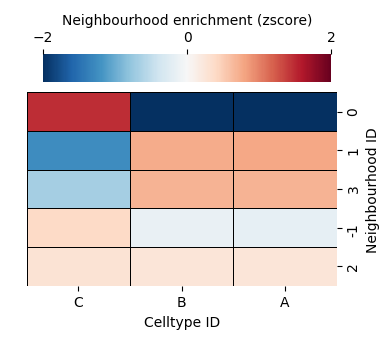

In [17]:
# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=unique_cluster_labels, columns=consistent_global_labels)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Celltype ID'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=consistent_global_labels,
    yticklabels=unique_cluster_labels,
    figsize=(4, 3.5),
    cmap='RdBu_r',
    dendrogram_ratio=(.05, .3),
    col_cluster=True,
    row_cluster=True,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (zscore)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)

### Summary
Neigbourhood clustering is a useful way of understanding the which cells are highly co-localised. MuSpAn offers the freedom to design your own neighbourhood clustering pipeline in a single function, allowing for custom analysis and interpretation.